##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Regression: predict fuel efficiency

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [ ]:
# Use seaborn for pairplot
!pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import keras
from keras.layers import Dense

## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).



### Get the data
First download the dataset.

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data


--2022-03-30 09:53:07--  http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30286 (30K) [application/x-httpd-php]
Saving to: ‘auto-mpg.data.1’

auto-mpg.data.1     100%[===================>]  29.58K  --.-KB/s    in 0.05s   

2022-03-30 09:53:07 (556 KB/s) - ‘auto-mpg.data.1’ saved [30286/30286]



Import it using pandas

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv('auto-mpg.data', names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

### Clean the data

The dataset contains a few unknown values.

In [ ]:
dataset.isna().sum()

To keep this initial tutorial simple drop those rows.

In [ ]:
#in altri modelli noi possiamo decidere di gestire in un certo modo anche i dati non noti
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [ ]:
#convertiremo le colonne in valori numerici
#in quanto sono completamente scorrelate tra loro,
#non vogliamo che la rete pensa che ci sia una relazione
#di ordine tra i valori 1 2 3 per quella colonna perche per
#quella colonna non c'è invece per gli altri valori c'è,
#il MLP si adatta ai tipi diversi delle features, ma non puo
#adattarsi in modo automatico al fatto che una variabile venga rappresentata
#con interi ma non ci sia una relazione di oridine tra quaesti valori
#è necessario per ottenere una rappresentazione corretta
print(dataset.columns) #stiamo printando il nome delle variabili

origin = dataset.pop('Origin') #la togliamo infatti nella print successiva non c'è più

print(dataset.columns)

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin'],
      dtype='object')
Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year'],
      dtype='object')


In [ ]:
#creeremo tre nuove colonne dicendo il nome delle colonne da inserire e poi gli diremo i valori da mettere
#all'interno della colonna(facciamo la moltiplicazione per un valore float in modo da ottenere valori float)
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [ ]:
#stiamo splittando i valori in training set e test set,facciamo uno split statico,
#ma poiche non sono molti i campioni, possiamo fare una cross validation alla fine, in cui
#noi faremo il training della rete k volte con ogni k caratterizzato da un validation set diverso
train_dataset = dataset.sample(frac=0.8,random_state=0) #il random è fisso in modo che l'esperimento sia riproducibile
test_dataset = dataset.drop(train_dataset.index) #andiamo a rimuovere quegli indici

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set using the [pairplot function](https://seaborn.pydata.org/generated/seaborn.pairplot.html).

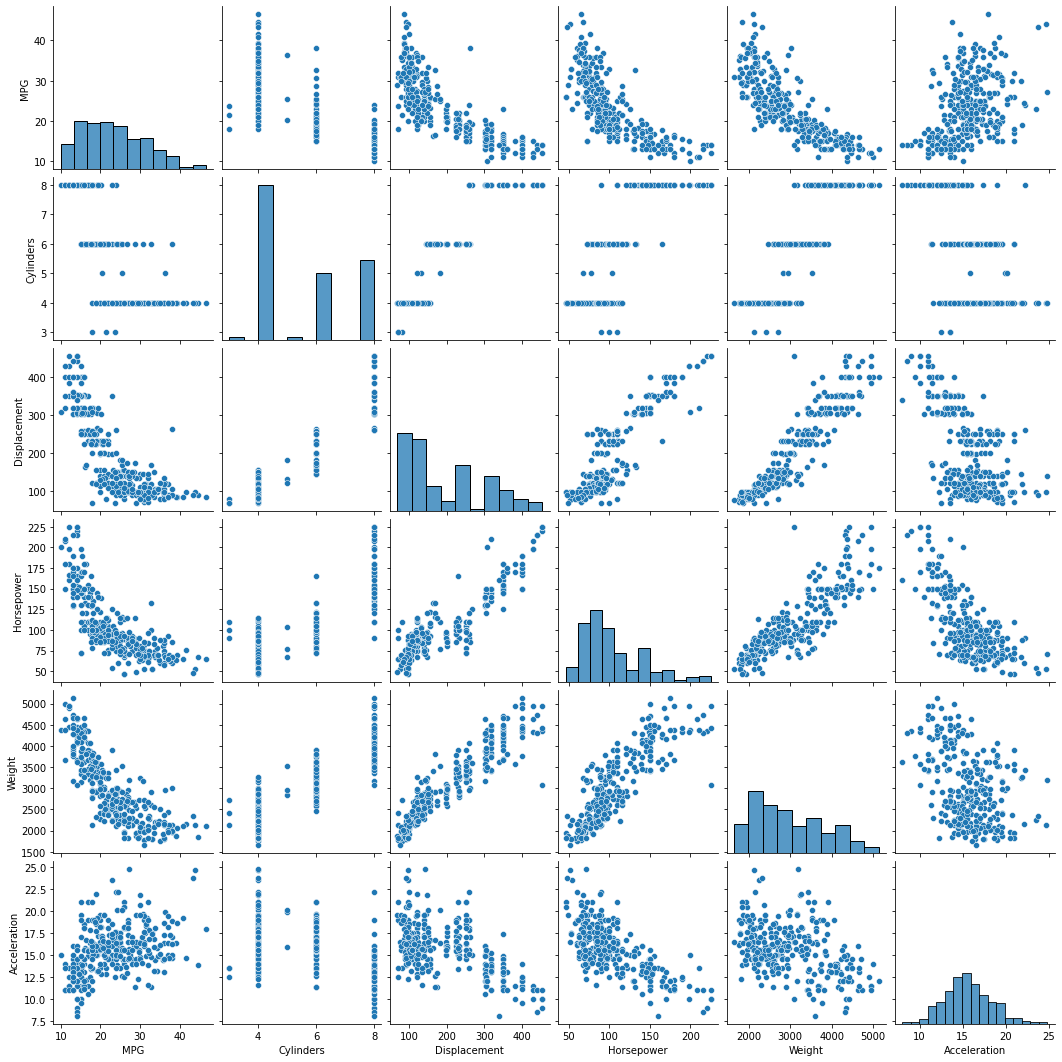

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration"]], diag_kind="hist")
plt.show()
#usiamo pairplot dis seaborn che serve per vedere come i nostri dati variano singolarmente e a coppie
#cioe prima solo il primo, poi primo e secondo, poi primo e terzo etc.
#cioe quello che noi vediamo e la combinazioni tra le variabili(colonne dei nostri dati) in modo da vedere
#eventualmente la correlazione che esiste tra le varie variabili.
#per esempio se vediamo che all'aumentare dell'uno aumenta anche l'altra significa che hanno un'elevata
#correlazione e wuindi se dovessimo rimuovere qualche features potremmo fare a meno di una delle due
#perche non ci arricchiscono di informazioni


Also look at the overall statistics:

In [ ]:
#il describe ci consente di capire diversi valori
train_stats = train_dataset.describe()
train_stats.pop("MPG") # the column we want to predict its values
train_stats = train_stats.transpose()
train_stats
#per ogni valore vediamo che abbiamo dei range di valori molto diversi, e dobbiamo tenerne conto
#altrimenti al MLP stiamo chiedendo di imparare dei valori molto diversi tra loro,
#questo non è un problema grande per la procedura di training anche se è meglio normalizzarlo
#in modo che tutti siano nello stesso range perche questo migliora la nostra procedura di
#training
#anche se il test set ha valori diversi da quelli del training la normalizzazione deve essere fatta anche
#sul test in modo uguale perche la training procedure è stata gestita con quella normalizzazione

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

In [ ]:
print(normed_train_data.tail())
print(normed_test_data.tail())

print('\n the size of data set for model input: {}'.format(len(train_dataset.keys())))

print('train_dataset.keys() return {}'.format(train_dataset.keys()))

     Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
281   0.307270      0.044872   -0.521559 -0.000298      0.946772    0.843910   
229   1.483887      1.961837    1.972127  1.457223     -1.598734    0.299787   
150  -0.869348     -0.836932   -0.311564 -0.710099     -0.021237   -0.516397   
145  -0.869348     -1.076553   -1.151543 -1.169870      1.233589   -0.516397   
182  -0.869348     -0.846517   -0.495310 -0.623596     -0.021237    0.027726   

          USA    Europe     Japan  
281  0.774676 -0.465148 -0.495225  
229  0.774676 -0.465148 -0.495225  
150 -1.286751 -0.465148  2.012852  
145 -1.286751 -0.465148  2.012852  
182 -1.286751  2.143005 -0.495225  
     Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
369  -0.869348     -0.798593   -0.442811 -0.705359      0.875068    1.660094   
375  -0.869348     -0.865687   -0.810302 -1.197124     -0.092942    1.660094   
382  -0.869348     -0.836932   -0.915299 -0.883106      0.48069

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [ ]:
#se vogliamo aggiungere altri layer dobbiamo aumentare questa lista presa in input
#l'output layer non ha activation function perche noi stiamo analizzando un valore continuo
#c'è un solo neurone alla fine che da il valore che vogliamo stimare
#utilizzeremo la MSE tra l'output desiderato e quello atteso,
def build_model(neurons_per_layer=[64, 64], activation='relu', optimizer='adam'):
  # compute the input shape from the train_dataset outer variable
  input_shape=[len(train_dataset.keys())]

  # create an empty sequential model
  model = keras.Sequential()
  # add the first Dense layer with the input_shape information
  model.add(Dense(neurons_per_layer[0],
                  activation=activation,
                  input_shape=input_shape))
  # add the intermediate layers
  for neurons in neurons_per_layer[1:]:
    model.add(Dense(neurons_per_layer[0],
                    activation=activation))
  # add the last output layer
  model.add(Dense(1))

  # compile the model
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
#prendiamo un batch e computiamo su questo anche se ora la training procedure per il momento non è proprio
#stata svolta
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.16188547],
       [-0.15090385],
       [-0.16342068],
       [ 0.01049747],
       [ 0.14071381],
       [-0.10153732],
       [ 0.11035039],
       [-0.00849668],
       [-0.07733189],
       [ 0.04194828]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
#qui stiamo definendo una callback user defined , controlla quando arrivano a 100 le epoche
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

#sono le stesse informazioni printate da tensorBoard
#utilizzeremo uno split tra training set e validation set
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.420313,0.969012,2.420313,10.482656,2.435461,10.482656,995
996,2.437835,0.989348,2.437835,10.448160,2.468680,10.448160,996
997,2.480045,0.982911,2.480045,10.416467,2.442967,10.416467,997
998,2.496507,1.001573,2.496507,10.584039,2.453762,10.584039,998
999,2.505933,0.996568,2.505933,10.479931,2.458010,10.479931,999


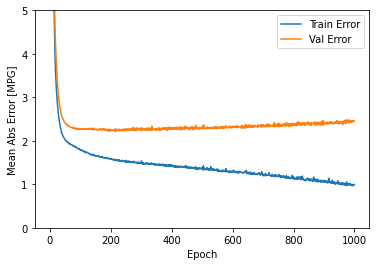

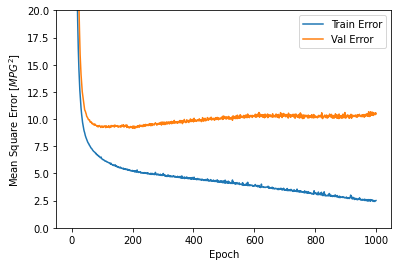

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


....................................................................................................
.................

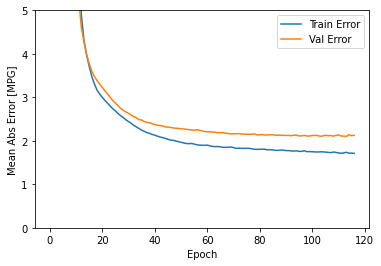

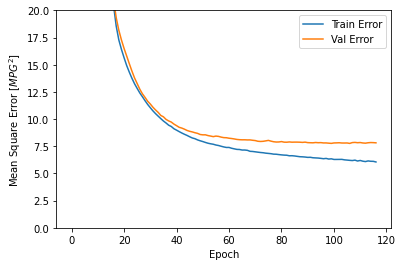

In [ ]:
#abbiamo reinizializzato il modello, e facciamo in modo da fermarci dopo dieci epoche che non vediamo
#piu un miglioramento, altrimenti ci saremmo tenuti come ultimo modello quello di prima, che
#era a richio di overfitting
#Le epoche non le cambiamo perche ci siamo accorti che siamo arrivati a convergenza con mille epoche in quanto
#l'errore sul validation set è rimasto statico altrimenti avremmo dovuto aumentarle
#inoltre reinizializziamo il modello perche è molto veloce rifare il training, se fosse stato come per le immagini piu lento
#ci conveniva salvare il valore migliore nel training precedente
#
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#poiche dopo un po avevamo visto che non c'erano miglioramenti all'aumentare delle epoche
#ora riproviamo mettendo un call back per stopparci prima
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.76 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

(78,)


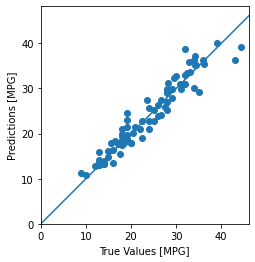

In [ ]:
#test_predictions = model.predict(normed_test_data)

test_predictions = model.predict(normed_test_data).flatten()
print(test_predictions.shape)

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])
plt.show()
#abbiamo fatto questa rappresentazione per vedere che sono uguali ed effettivamente è abbastanza cosi
#perche si trovano sulla stessa linea
#vediamo che l'errore maggiormente è tra 30 e 40 probabilmente perche per questi abbiamo meno campioni.

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

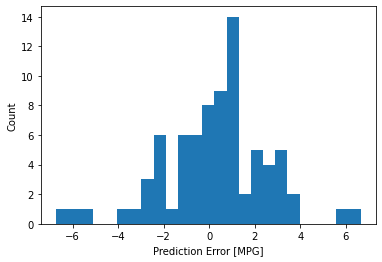

In [ ]:
#vediamo la distribuzione dei nostri errori, dunque questo ci dice che per esempio per 14 voltw l'errore è stato zero
#vediamo anche degli outlayer a -6 e 6
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

# Exercise
Implement a cross-validation strategy to better estimate the model performance when used in production.

To access the DataFrame use the pandas [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) function as shown below.

In [ ]:
#partendo dallo split training test split fatto sopra, fare cross validation sfruttando la iloc functions che serve per
#estrarre dei valori da un data frame
# Show the first two rows of the dataset
dataset.head(2)

In [ ]:
# Extract the first row
first_row = dataset.iloc[[0]]

# Print the first row
print('First row:\n', first_row)

# Print the first row index (shall be used to drop the sample from the dataset to complete the split)
print('\nFirst row index:', first_row.index)

In [ ]:
# Repeat for the second row
second_row = dataset.iloc[[1]]
print('Second row:\n', second_row)
print('\nSecond row index:', second_row.index)